In [1]:
import numpy as np
import cPickle as pickle
from fatiando.gravmag import polyprism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion import Damping
from fatiando import gridder, utils, mesher
from fatiando.vis import mpl

/home/vanderlei/anaconda2/envs/SEGEO2017/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
# Carrega um modelo
with open('../modelos/modelo1.pickle') as f:
        model = pickle.load(f)

In [3]:
model['bounds']

[0, 5000, 1000, 6000, 0, 2000]

In [4]:
intens, incs, decs = utils.vec2ang(model['modelo'][0].props['magnetization'])

print intens, incs, decs

8.0 -30.0 10.0


In [5]:
shape = (50, 50)
area = model['bounds'][:4]
x, y, z = gridder.regular(area, shape, z=-150)

In [6]:
inc, dec = -10, 40

tf = utils.contaminate(polyprism.tf(x, y, z, model['modelo'], inc, dec), 5, seed=0)

In [7]:
layer = mesher.PointGrid(area, 200, shape)

In [8]:
misfit = EQLTotalField(x, y, z, tf, inc, dec, layer, sinc=incs, sdec=decs)
regul = Damping(layer.size)

In [10]:
factor = np.trace(misfit.hessian())/layer.size

In [15]:
solver = (misfit + 1e-3*factor*regul).fit()

In [16]:
residuals = solver[0].residuals()
layer.addprop('magnetization', solver.estimate_)
print("Residuals:")
print("mean:", residuals.mean())
print("stddev:", residuals.std())

Residuals:
('mean:', -0.048583641827923074)
('stddev:', 3.6420278090183675)


In [17]:
layer_pole = layer.copy()
layer_pole.addprop('magnetization', utils.ang2vec(solver.estimate_, -90, 0))
tfreduced = sphere.tf(x, y, z, layer_pole, -90, 0)

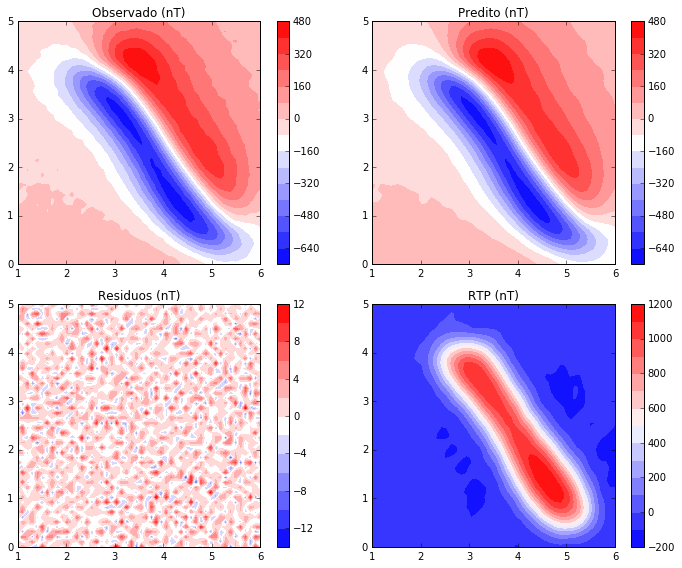

In [18]:
mpl.close('all')
mpl.figure(figsize=(10, 8))

mpl.subplot(2, 2, 1)
mpl.axis('scaled')
mpl.title('Observado (nT)')
mpl.contourf(y, x, tf, shape, 15, cmap = mpl.get_cmap('bwr'))
mpl.colorbar()
mpl.m2km()

mpl.subplot(2, 2, 2)
mpl.axis('scaled')
mpl.title('Predito (nT)')
mpl.contourf(y, x, solver[0].predicted(), shape, 15, cmap = mpl.get_cmap('bwr'))
mpl.colorbar()
mpl.m2km()

mpl.subplot(2, 2, 3)
mpl.axis('scaled')
mpl.title('Residuos (nT)')
mpl.contourf(y, x, solver[0].predicted() - tf, shape, 15, cmap = mpl.get_cmap('bwr'))
mpl.colorbar()
mpl.m2km()

mpl.subplot(2, 2, 4)
mpl.axis('scaled')
mpl.title('RTP (nT)')
mpl.contourf(y, x, tfreduced, shape, 15, cmap = mpl.get_cmap('bwr'))
mpl.colorbar()
mpl.m2km()

mpl.tight_layout()

mpl.show()